## Версия с большинством функций. Базовый и экспертный режимы.

In [1]:
import enum
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# planet X - 'X'
# comet - 'C'
# dwarf planet - 'D'
# nebula - 'N'
# asteroid - 'A'
# empty sector -'E'

class objects(enum.IntEnum):
    not_chosen = 0
    X = 1
    C = 2
    D = 3
    N = 4
    A = 5
    E = 6
    
comet_available = [1,2,4,6,10,12,16] # basic and expert are same

In [3]:
available_basic = [objects.A]*4 + [objects.C]*2 + [objects.D]*1 + [objects.E]*2 + [objects.N]*2
available_expert = [objects.A]*4 + [objects.C]*2 + [objects.D]*4 + [objects.E]*5 + [objects.N]*2

In [4]:
def check_limit(situation, idx_A, obj_B, limit) -> bool:
    '''
    checks if there {obj_B} in {limit} sectors from sector with index {idx_A}
    idx are in range [0...len(situation)-1]
    '''
    l = len(situation)
    for i in range(1, limit+1):
        next_i = (idx_A+i)%l
        prev_i = (idx_A-i)%l
        if situation[next_i] == obj_B or situation[prev_i] == obj_B:
            return True
    return False
    

def cond_limit(all_situations, obj_A, count_A, obj_B, limit, presence=True) -> list:
    '''
    condition is not less than {count_A} {obj_A} {is} in {limit} sectors from {obj_B}
    where {is} - is presence (bool)
    '''
    chosen_situations = []
    for sit in all_situations:
        cnt = 0
        for i, obj in enumerate(sit):
            if obj == obj_A and check_limit(sit, i, obj_B, limit) == presence:
                cnt += 1
                
        if cnt >= count_A:
            chosen_situations.append(sit)
    
    return chosen_situations

def check_area(situation, obj, number_of_sectors):
    '''
    checks if there all {obj} in area {number_of sectors} sectors
    '''
    l = len(situation)
    for i in range(l):
        start = i
        end = (i+number_of_sectors)%l
        chosen_sectors = situation[start-1:] + situation[:end] if start>end  else situation[start-1:end]
        if situation.count(obj) == chosen_sectors.count(obj):
            return True
    
    return False
    
def cond_area(all_situations, obj, number_of_sectors):
    '''
    condition if there all {obj} in area {number_of sectors} sectors
    '''
    
    chosen_situations = [sit for sit in all_situations if check_area(sit, obj, number_of_sectors)]
    return chosen_situations
    
    
    

In [5]:
def check_pos(situation, basic = True):
    '''
    Checks if the board is correct
    Parameters
    situation: the situation to check
    basic: sets if you need basic game or expert (set basic to False if you need expert game)
    
    Return 
    - True if the board is correct
    - False if something on the board is wrong
    '''
    l = len(situation)
    for i, el in enumerate(situation):
        prev_idx = (i-1)%l
        next_idx = (i+1)%l
        
        if el == objects.X:
            if situation[prev_idx] == objects.D or situation[next_idx] == objects.D:                
                return False
                
        elif el == objects.C:
            if i not in comet_available:
                return False      

        elif el == objects.N:
            if situation[prev_idx] != objects.E and situation[next_idx] != objects.E:
                return False

        elif el == objects.A:
            if situation[prev_idx] != objects.A and situation[next_idx] != objects.A:
                return False
            
    if not basic:
        for i in range(l):
            if situation[i] != objects.D:
                continue
            start = i
            end_6 = (i+6)%l
            end_5 = (i+5)%l
            chosen_sectors_6 = situation[start:] + situation[:end_6] if start>end_6  else situation[start:end_6]
            chosen_sectors_5 = situation[start:] + situation[:end_5] if start>end_5  else situation[start:end_5]
            if chosen_sectors_6.count(objects.D) == 4 and chosen_sectors_5.count(objects.D) != 4:
#                 print(chosen_sectors_6, chosen_sectors_5)
                return True
    
        return False

    return True

def recursive_put(cur_pos, available, to_place):
    '''
    recursive function to get all board situations
    '''
    l = len(cur_pos)
    if cur_pos[to_place] != objects.not_chosen:
        if check_pos(cur_pos, l==12): # this check if game is basic or expert
            return cur_pos
    
    situations = []
    def copy_and_add(cur_pos, obj, to_place, available, where):
        pos = cur_pos.copy()
        pos[to_place] = obj
        ret = recursive_put(pos,available, (to_place+1)%len(pos))
        
        if isinstance(ret, list) and len(ret)>0:
            if isinstance(ret[0], int):
                where.append(ret)
            elif isinstance(ret[0], list):
                where += ret      
    
    pprev_idx = (to_place-2)%l
    prev_idx = (to_place-1)%l
    next_idx = (to_place+1)%l
    
    if cur_pos[prev_idx] == objects.A and cur_pos[pprev_idx] != objects.A:
        if objects.A in available:
            idx = available.index(objects.A)
            copy_and_add(cur_pos, objects.A, to_place, available[:idx]+available[idx+1:], situations)
        else:
            return -1
    
    elif cur_pos[prev_idx] == objects.N and cur_pos[pprev_idx] != objects.E:
        if objects.E in available:
            idx = available.index(objects.E)
            copy_and_add(cur_pos, objects.E, to_place, available[:idx]+available[idx+1:], situations)
        else:
            return -1
        
    else:
        idxs_av = [available.index(el) for el in objects if available.count(el)]
        unique_available = [available[i] for i in idxs_av]
        for i, el in zip(idxs_av, unique_available):
            if el == objects.X:
                if cur_pos[prev_idx] != objects.D and cur_pos[next_idx] != objects.D:
                    copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)

            elif el == objects.C:
                if to_place in comet_available:
                    copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)

            elif el == objects.D:
                if cur_pos[prev_idx] != objects.X and cur_pos[next_idx] != objects.X:
                    copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)        

            elif el == objects.N:
                copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)

            elif el == objects.A:
                copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)

            elif el == objects.E:
                copy_and_add(cur_pos, el, to_place, available[:i]+available[i+1:], situations)         
        
    return situations

### Все базовые ситуации

In [6]:
%%time
def get_basic_situations():
    all_basic_situations = []
    for planet_X_idx in range(12):
        start_pos = [objects.not_chosen]*planet_X_idx + [objects.X] + [objects.not_chosen]*(11-planet_X_idx)
        situations_i = recursive_put(start_pos, available_basic, (planet_X_idx+1)%12)
        all_basic_situations += situations_i
    return all_basic_situations

Wall time: 0 ns


### Все экспертные ситуации

In [13]:
%%time
start_pos =  [objects.X] + [objects.not_chosen]*17
A = recursive_put(start_pos, available_expert, 1)

KeyboardInterrupt: 

In [14]:
n = np.random.randint(len(A))
len(A), n, A[n]

NameError: name 'A' is not defined

In [75]:
%%time
expert_situations_A = []
for el in A:
    if el not in expert_situations_A:
        expert_situations_A.append(el)
    else:
        print(el, A.index(el))
        visualize_situation(el)
        break
len(expert_situations_A)

Wall time: 1min 5s


66264

In [7]:
def get_expert_situations():
    all_expert_situations = []
    for planet_X_idx in range(18):
        start_pos = [objects.not_chosen]*planet_X_idx + [objects.X] + [objects.not_chosen]*(17-planet_X_idx)
        situations_i = recursive_put(start_pos, available_expert, (planet_X_idx+1)%18)
        all_expert_situations += situations_i
    return all_expert_situations 
    

### Все ситуации

In [8]:
def get_situations(basic=True) -> list:
    '''
    get all possible situations
    Parameters
    basic: if True (default) return all basic situations
        else return all expert situations
        
    Returns
    all possible situations, list
    '''
    if basic:
        return get_basic_situations()
    else:
        return get_expert_situations()


In [30]:
%%time
all_basic_situations = get_situations(basic=True)
len(all_basic_situations)

Wall time: 821 ms


4446

In [18]:
%%time
all_expert_situations = get_situations(basic=False)
len(all_expert_situations)

KeyboardInterrupt: 

### Вероятностное распределение для выбранных ситуаций

In [63]:
def obj_prob(obj, situations):
    '''
    
    Parameters
    
    '''
    count = [0]*len(situations[0])
    for sit in situations:
        for i, ob in enumerate(sit):
            count[i] += (1 if ob == obj else 0)
    p = [el/len(situations) for el in count]
    return p

In [64]:
def get_sector_prob(situations) -> list:
    '''
    returns distribution of objects in each sector
    Parameters
    situations: all situations from which the ditribution will be created
    
    Returns
    list of sectors with non-zero probabilities of objects
    '''
    if len(situations) == 0:
        raise AttributeError('zero-len situations')
    l_s = len(situations[0])
    sector_prob = [[] for _ in range(l_s)]

    for obj in objects:
        if obj == objects.not_chosen:
            continue
        P = obj_prob(obj, situations)
        for i, p in enumerate(P):
            sector_prob[i].append([obj, p])
        
    return sector_prob


In [65]:
def get_objects_prob(situations) -> list:
    '''
    returns distribution of each object over sectors
    Parameters
    situations: all situations from which the ditribution will be created
    
    Returns
    list of non-zero probabilities of objects over sectors
    '''
    if len(situations) == 0:
        raise AttributeError('zero-len situations')
    l_s = len(situations[0])
    objects_prob = [[0]*l_s for _ in range(len(objects)-1)]

    for obj in objects:
        if obj == objects.not_chosen:
            continue
        P = obj_prob(obj, situations)
        objects_prob[obj.value-1] = P
        
    return objects_prob
    
    

In [66]:
def visualise_sector_prob(situations):
    sector_prob = get_sector_prob(situations)

    fig, axs = plt.subplots(nrows=4, ncols=3, dpi = 100, figsize = (8*3,8*4))
    sp = np.array(sector_prob)

    values = sp[:, :,1]
    names = [list(map(lambda x: objects(x).name, el)) for el in list(sp[:, :,0])]

    def make_autopct(values, acc=2):
        def my_autopct(pct):
            total = sum(values)
            return f'{np.round(pct, acc)}%' if pct >0 else ''
        return my_autopct

    for i in range(12):
        patches, texts, _ = axs[i//3][i%3].pie(values[i], labels = names[i], autopct = make_autopct(values[i]), startangle=90, explode=[0.02]*len(values[i]))
        axs[i//3][i%3].set(title = f'Сектор {i+1}')
    #     axs[i//3][i%3].legend(patches, names[i], loc="best") # if you need legend just uncomment this
    plt.show()
    return


In [67]:
def visualise_objects_prob(situations):
    objects_prob = get_objects_prob(situations)

    fig, axs = plt.subplots(nrows=3, ncols=2, dpi = 100, figsize = (8*2,8*3))
    names = list(range(1,13))
    comet_names = ['', 2, 3, '', 5, '', 7, '', '' , '', 11, '']

    colors = list(plt.cm.winter(np.linspace(0.4,0.9,6))) + list(plt.cm.autumn(np.linspace(0.2,0.9,6)))
    def make_autopct(values, acc=2):
        def my_autopct(pct):
            return f'{np.round(sum(values)*pct, acc)}%' if pct>0 else ''
        return my_autopct


    for i in range(len(objects)-1):
        names_i = names if objects(i+1).name != 'C' else comet_names
        patches, texts, _ = axs[i//2][i%2].pie(objects_prob[i], labels = names_i, autopct = make_autopct(objects_prob[i]),\
                                               startangle=90, explode=[0.02]*len(objects_prob[i]), counterclock=False, colors = colors)
        axs[i//2][i%2].set(title = f'{objects(i+1).name}')
    plt.show()
    return


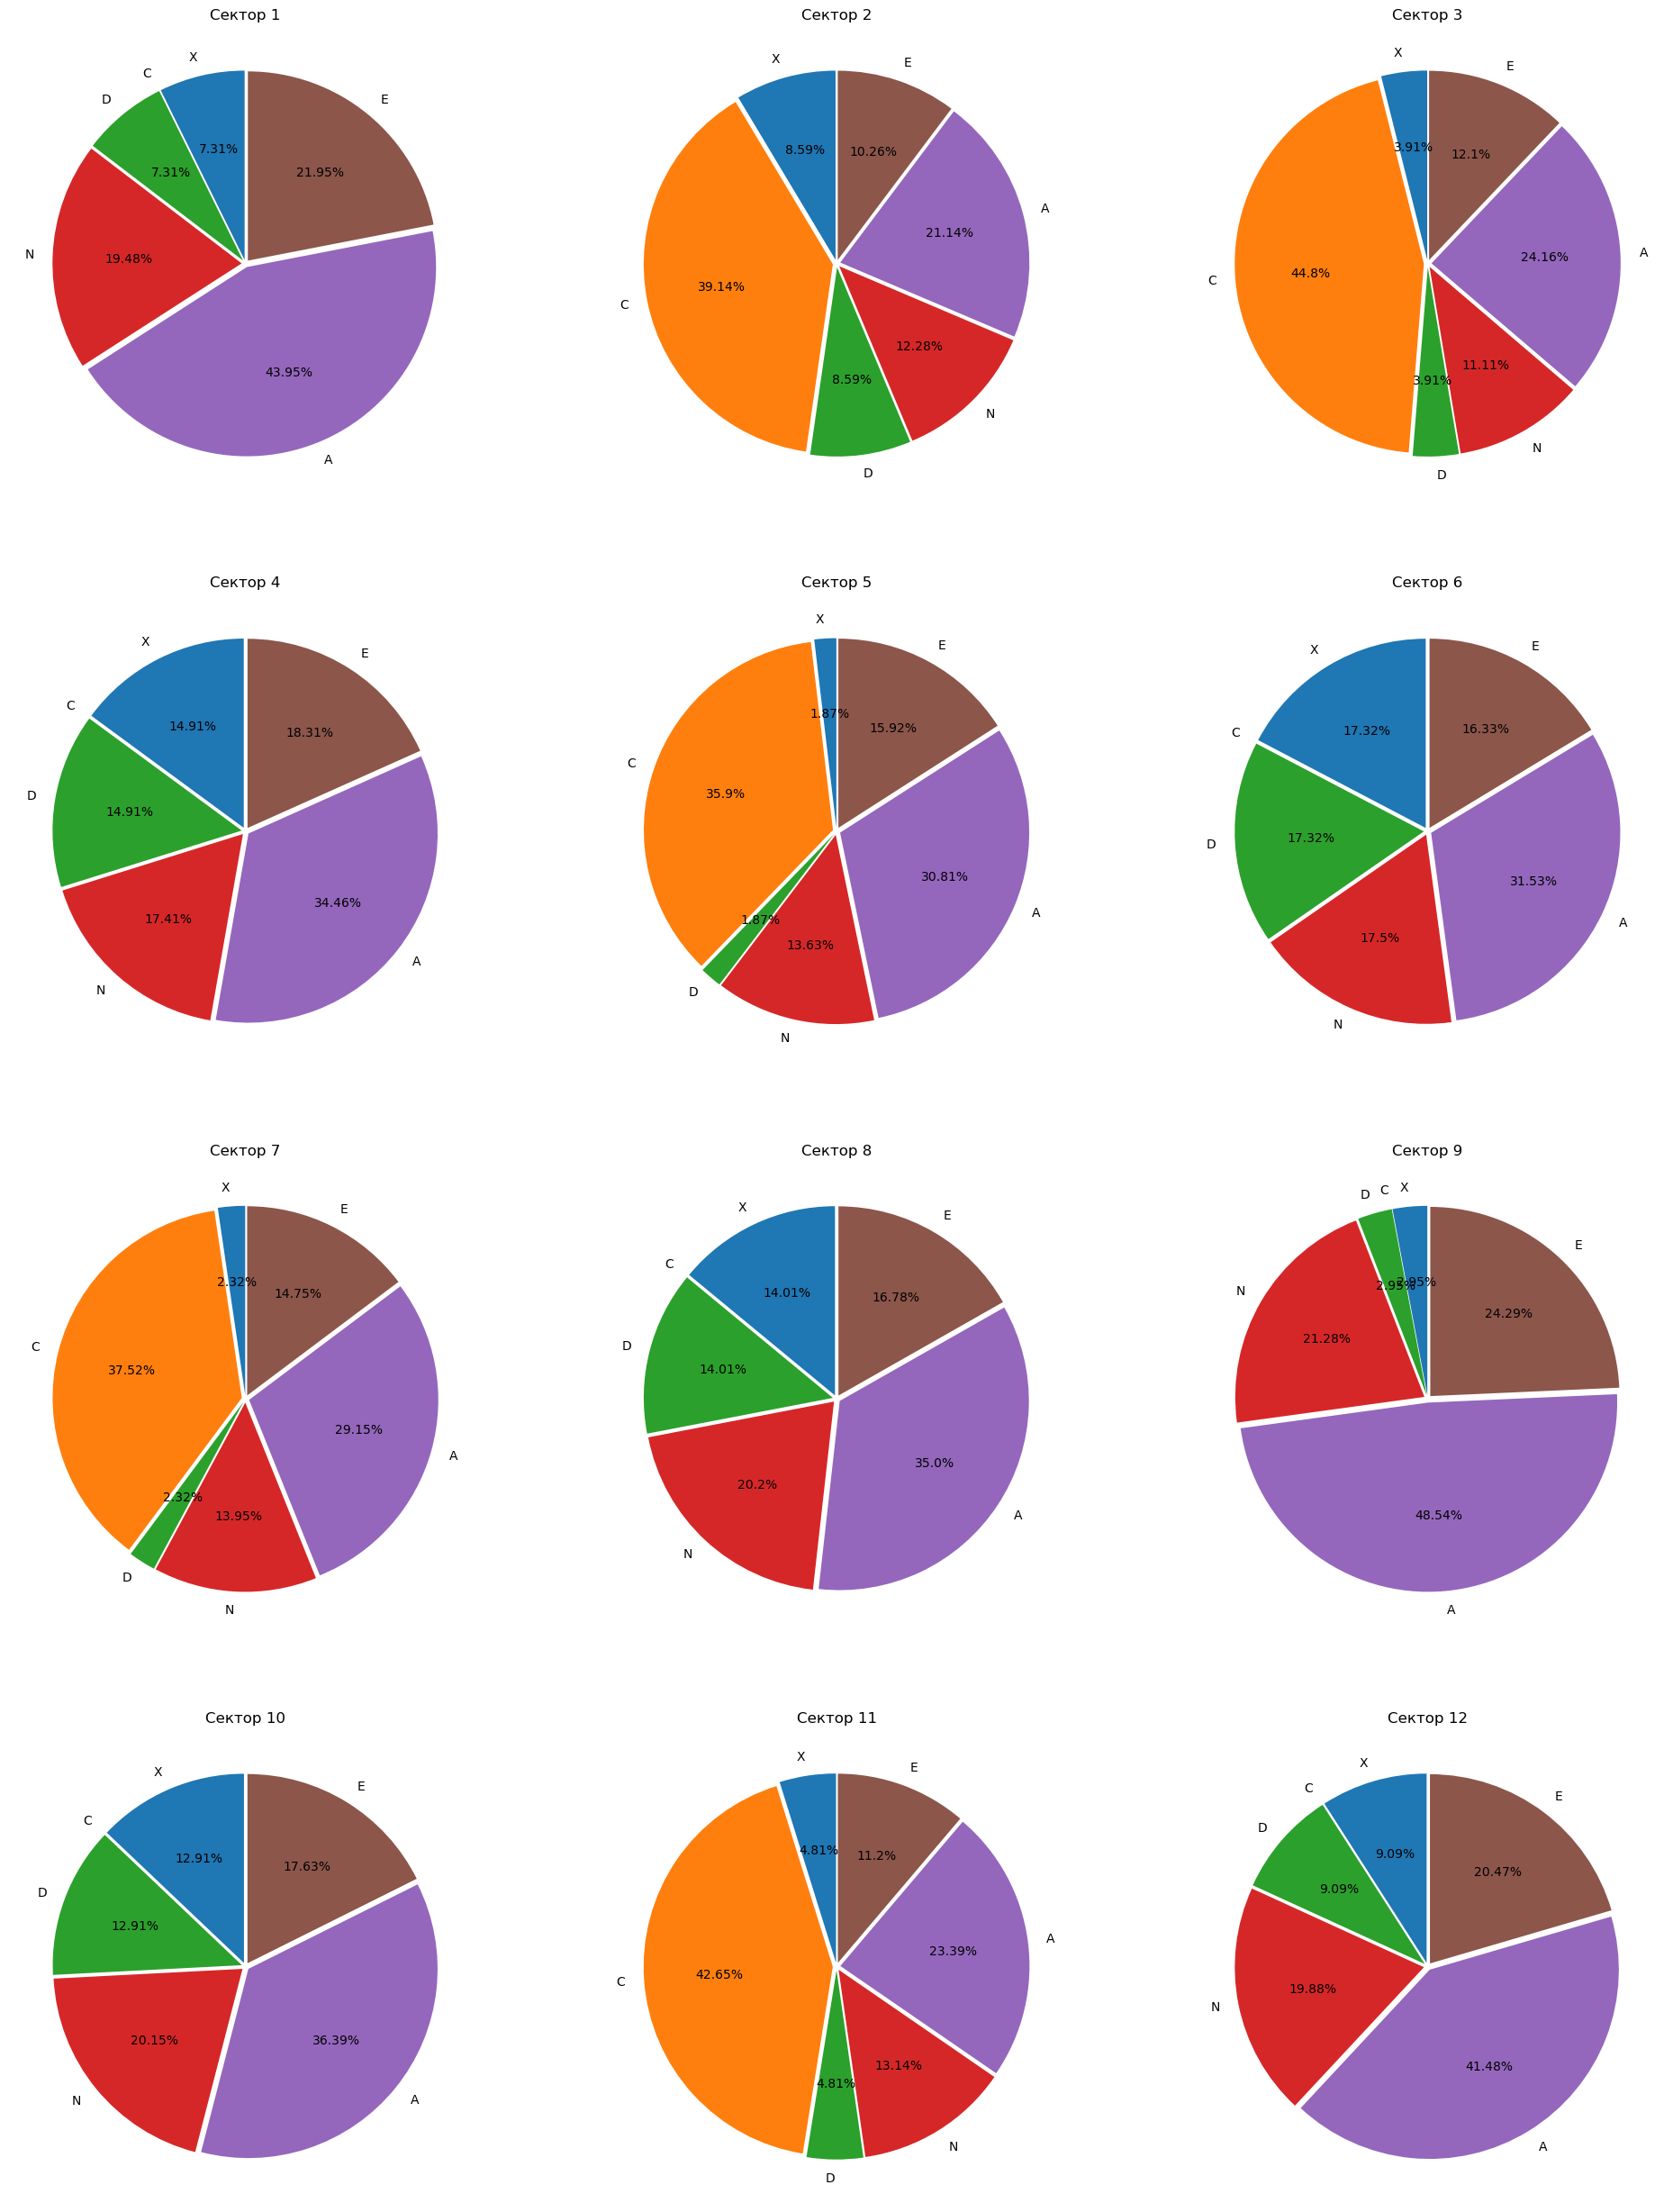

In [68]:
visualise_sector_prob(all_basic_situations)

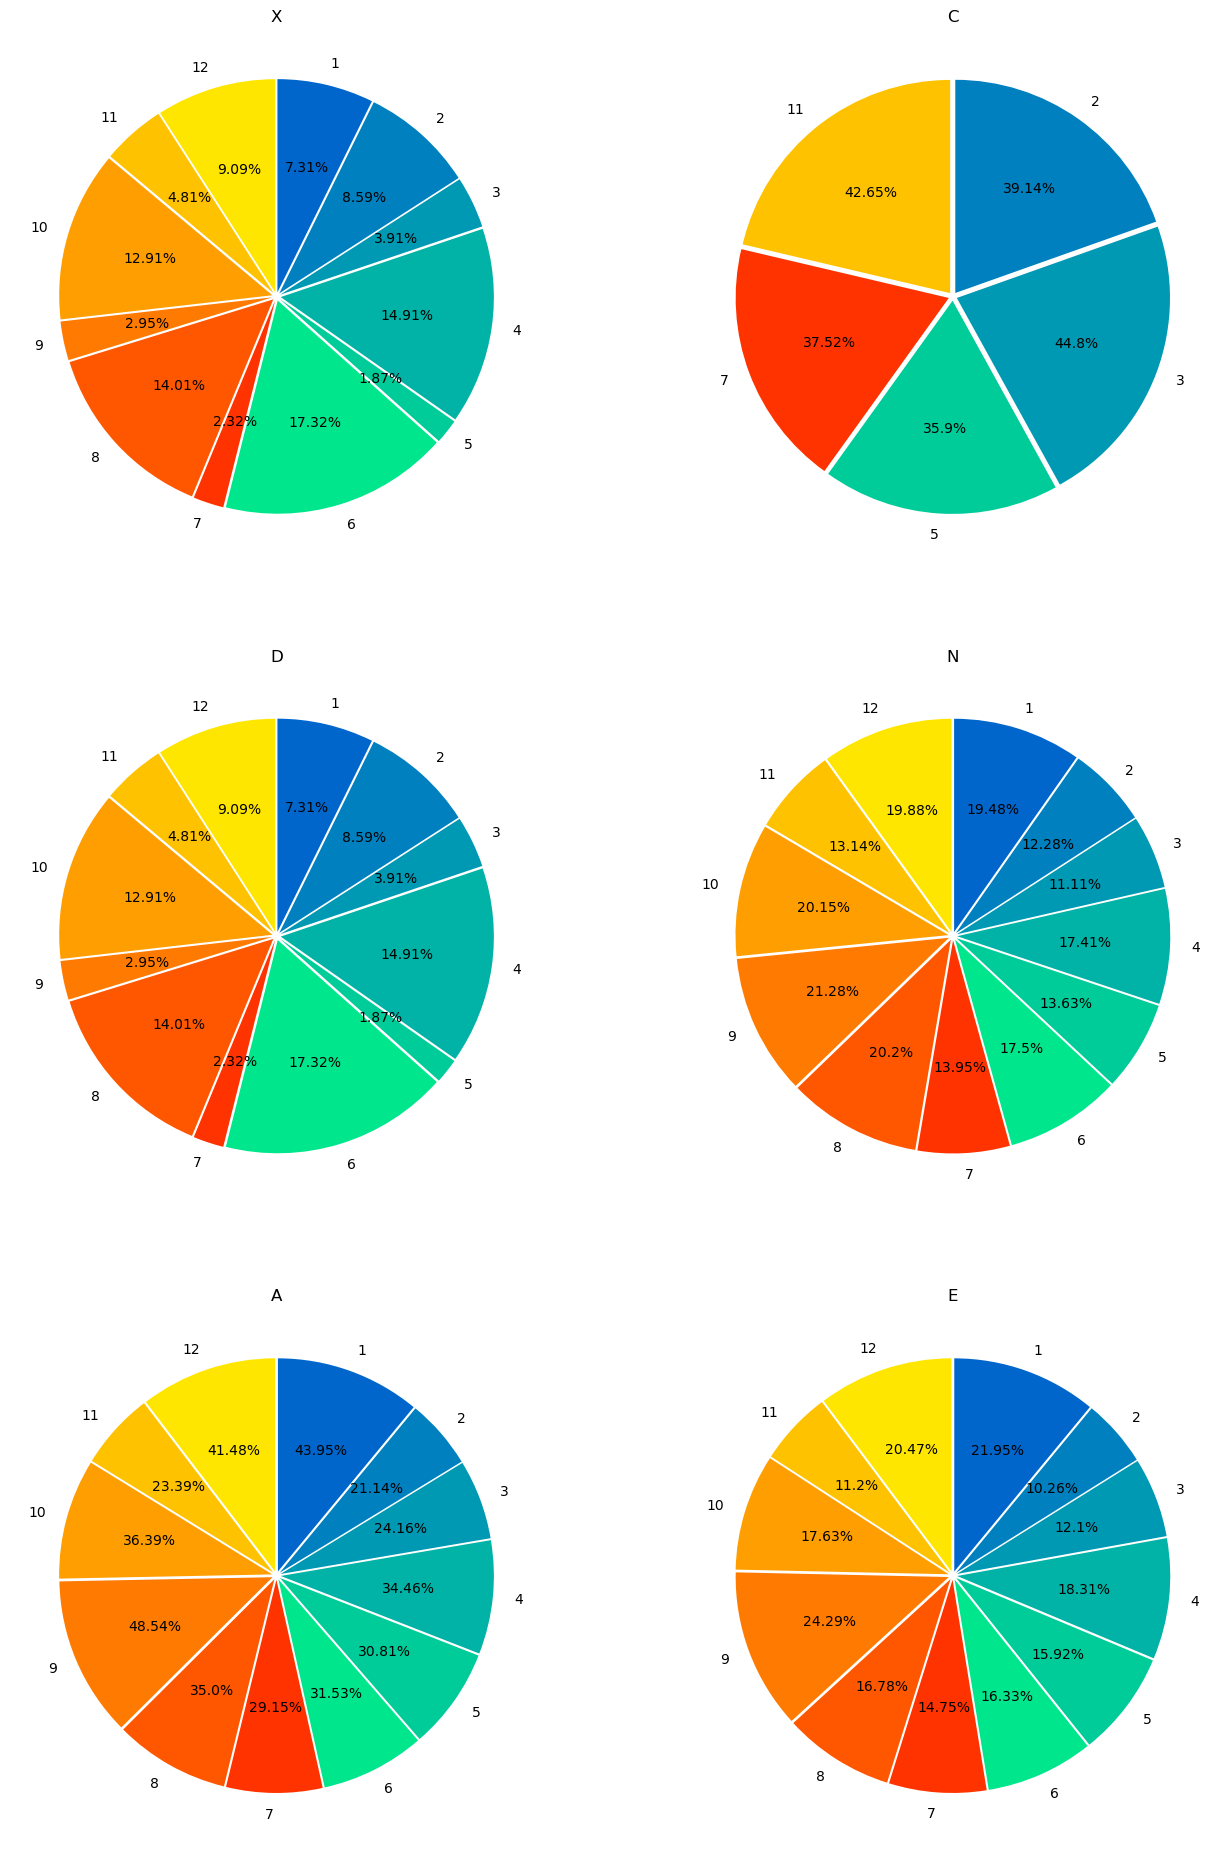

In [69]:
visualise_objects_prob(all_basic_situations)

### Вероятности при поиске и т.п.

In [36]:
def find_prob(obj, start, end, situations):
    l = len(situations[0])
    if start > l or end > l or start < 1 or end < 1:
        return -1
    
    counts = [0]*5
    for sit in situations:
        cnt = 0
        b = sit[start-1:] + sit[:end] if start>end else sit[start-1:end]
        for ob in b:
            if ob == obj:
                cnt +=1
        counts[cnt] +=1
    
    s = len(situations)
    probs = dict()
    for i, el in enumerate(counts):
         if el > 0:
            probs[i] = el/s
                
    return probs

In [37]:
def fixed_object_prob(obj, obj_count, start_sector, end_sector, situations, count_return = False):
    l = len(situations[0])
    start = start_sector
    end = end_sector
    if start > l or end > l or start < 1 or end < 1:
        return -1
    
    K = end-start+1 if end>start else (end+l-start+1)
    if K > l//2:
        return -2
    
    chosen_situations_sectors = []
    for sit in situations:
        chosen_sectors = sit[start-1:] + sit[:end] if start>end else sit[start-1:end]
        if chosen_sectors.count(obj) == obj_count:
            chosen_situations_sectors.append(sit)
    
    sector_count = [0]*l
    if len(chosen_situations_sectors) !=0:
        for sit in chosen_situations_sectors:
            for i, el in enumerate(sit):
                if el == obj:
                    sector_count[i] += 1

        sector_prob = [el/len(chosen_situations_sectors) for el in sector_count]
    else:
        sector_prob = [0]*l
    
    if count_return:
        return sector_prob, sector_count
    else:
        return sector_prob
    

In [38]:
def cond_situtations(all_situations, conditions):
    '''
    conditions must be in form of triples [object, sector, 0/1]
    where 0 - object isn't here
        1 - object is here
    '''
    chosen = []
    for sit in all_situations:
        flag = True
        for cond in conditions:
            obj, sector, presence = cond
            if bool(sit[sector-1] == obj) != presence:
                flag = False
                break
        
        if flag:
            chosen.append(sit)
    
    return chosen
    

In [39]:
def visualize_situation(situation):
    fig, axs = plt.subplots(1,1, figsize=(10,10))
    colors_d = [[0]*4] + list(plt.cm.winter(np.linspace(0.3,0.9,3))) + list(plt.cm.autumn(np.linspace(0.1,0.9,3)))
    colors = [colors_d[el] for el in situation]
    indexes = [situation.index(el) for el in objects if situation.count(el)]
    patches, texts = plt.pie([1]*len(situation), startangle=90, explode=[0.02]*len(situation), counterclock=False, labels = list(range(1,len(situation)+1)), colors = colors)
    patches_idx = [patches[i] for i in indexes]
    names = [el.name for el in situation]
    names_idx = [names[i] for i in indexes]
    plt.legend(patches_idx, names_idx, loc="best") # if you need legend just uncomment this
    plt.show()

### Коды из реальной игры

In [114]:
def get_codes(s):
    codes = []
    mode = 'wait'
    cur_code = ''
    for i, el in enumerate(s):
        if el == '"':
            if mode == 'wait':
                mode = 'write'
                
            elif mode == 'write':
                mode = 'wait'
                codes.append(cur_code)
                cur_code = ''
        else:
            if mode == 'wait':
                continue
            elif mode == 'write':
                cur_code = cur_code + el
                
    return codes

In [116]:
with open('px.txt') as f:
    A = f.read().split(':')
    A = A[1:]
    b = A[0].split('\n')[0]
    e = A[1].split('\n')[0]
    codes_simple = get_codes(b)
    codes_expert = get_codes(e)

In [117]:
len(codes_simple), len(codes_expert)

(1855, 3188)

In [119]:
codes_simple[-20:]

['K8T8',
 'K8U2',
 'K8U4',
 'K8U5',
 'K8U6',
 'K8U8',
 'K8W2',
 'K8W5',
 'K8W8',
 'K8X5',
 'K8X6',
 'K8X7',
 'K8X8',
 'K8X9',
 'K8Y3',
 'K8Y8',
 'K8Z2',
 'K8Z5',
 'K8Z6',
 'K8Z8']

### Чтение игровых ситуаций

In [10]:
def read_json(file_path):
    with open(file_path) as file:
        s = file.read()
    s1 = s[s.index('obj'):]
    s2 = s1[s1.index('{'):s1.index('}')]
    situation = []
    obj_dict = {0:objects.E, 1:objects.A, 2:objects.D, 3:objects.C, 4:objects.N, 9:objects.X}
    
    max_sit = 12
    if s2.count('18'):
        max_sit = 18
    for i in range(max_sit):
        obj_i = f'"{i+1}"'
        obj_int = int(s2[s2.index(obj_i)+2+len(obj_i)])
#         print(obj_int)
        situation.append(obj_dict[obj_int])
    
    return situation

### Чтение и разбор всех базовых ситуаций

In [19]:
def get_codes(s):
    codes = []
    mode = 'wait'
    cur_code = ''
    for i, el in enumerate(s):
        if el == '"':
            if mode == 'wait':
                mode = 'write'
                
            elif mode == 'write':
                mode = 'wait'
                codes.append(cur_code)
                cur_code = ''
        else:
            if mode == 'wait':
                continue
            elif mode == 'write':
                cur_code = cur_code + el
                
    return codes

In [21]:
with open('keys_basic.txt') as f:
    A = f.read()
    codes_simple = get_codes(A[1:-1])


In [29]:
%%time
real_basic_situations = []
for key in codes_simple:
    sit = read_json("json basic/"+key+".json")
    real_basic_situations.append(sit)
    
real_basic_situations[0], len(real_basic_situations)

Wall time: 240 ms


([<objects.A: 5>,
  <objects.A: 5>,
  <objects.C: 2>,
  <objects.X: 1>,
  <objects.C: 2>,
  <objects.E: 6>,
  <objects.D: 3>,
  <objects.N: 4>,
  <objects.E: 6>,
  <objects.N: 4>,
  <objects.A: 5>,
  <objects.A: 5>],
 1822)

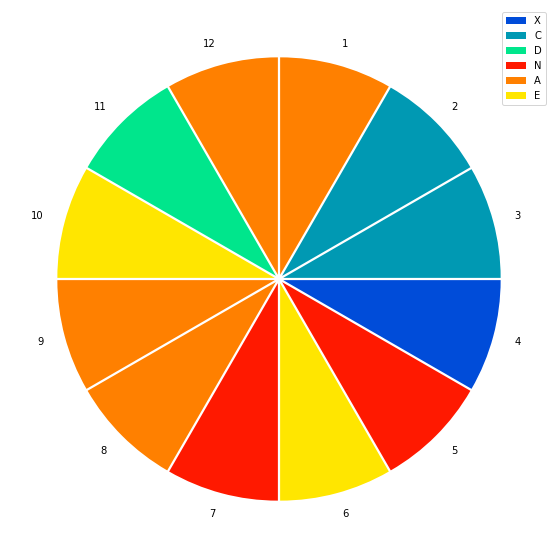

In [74]:
visualize_situation(real_basic_situations[np.random.randint(len(real_basic_situations))])

### Визуализация распределений реальных ситуаций

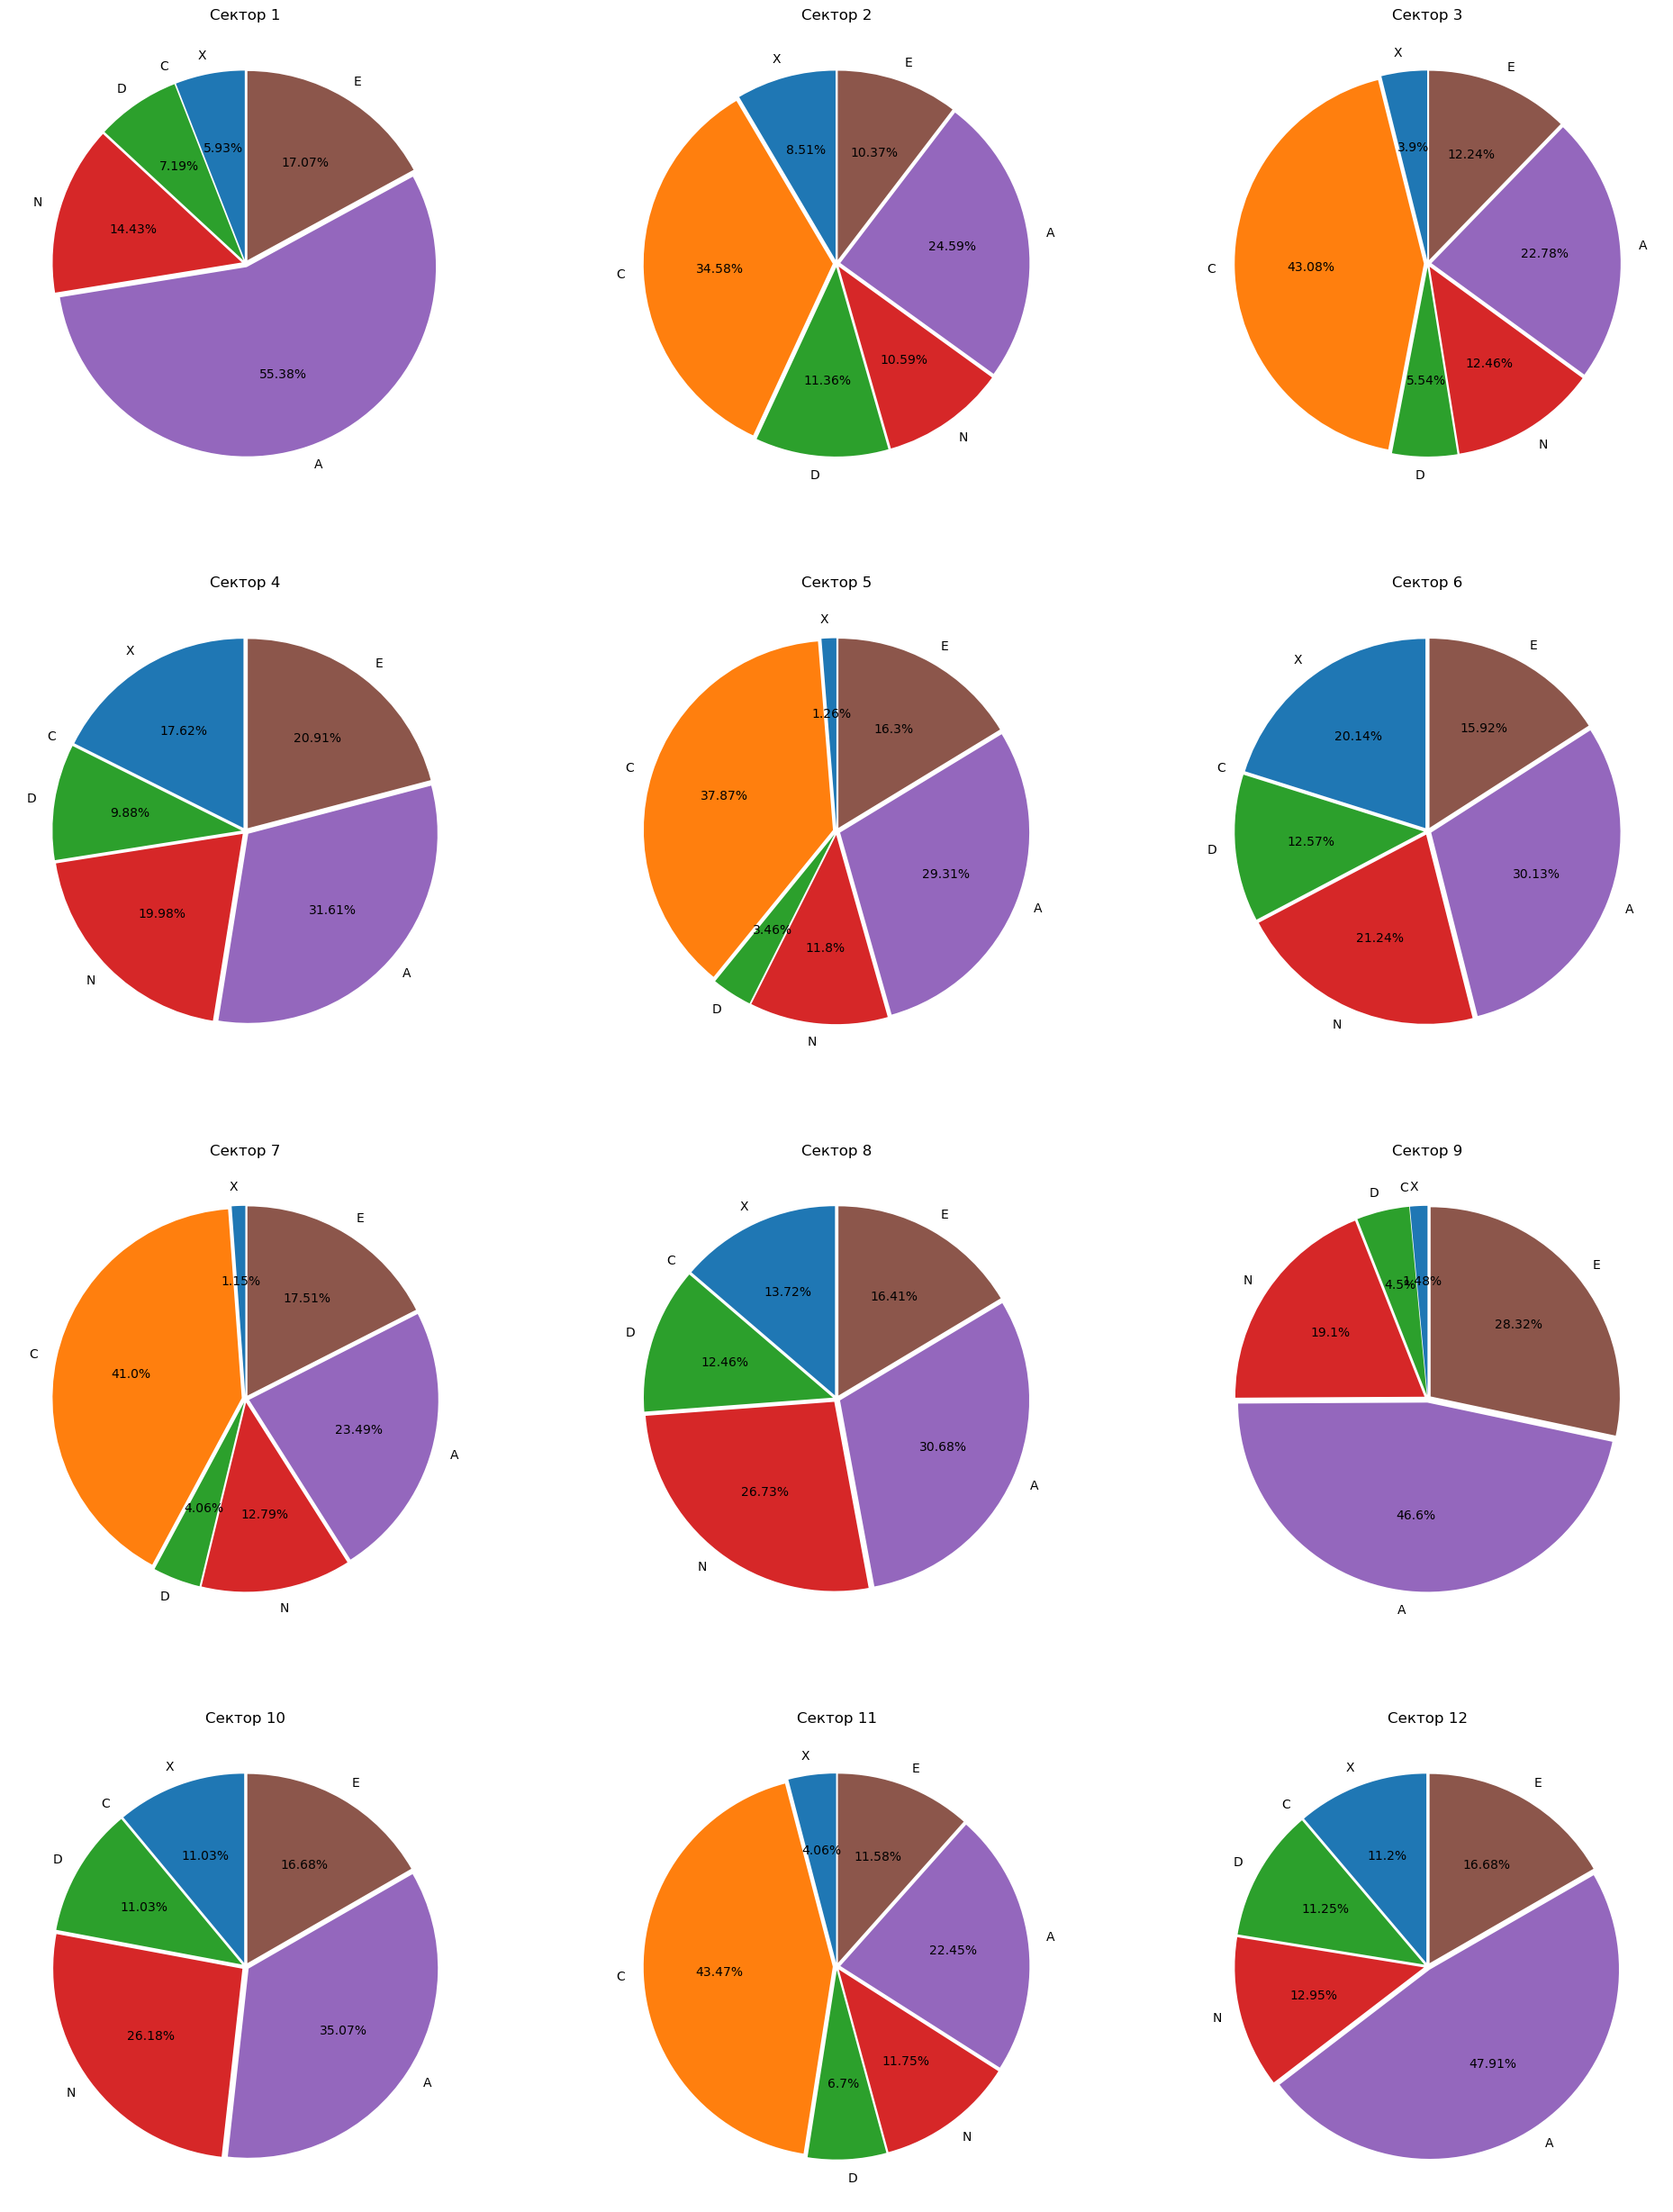

In [75]:
visualise_sector_prob(real_basic_situations)

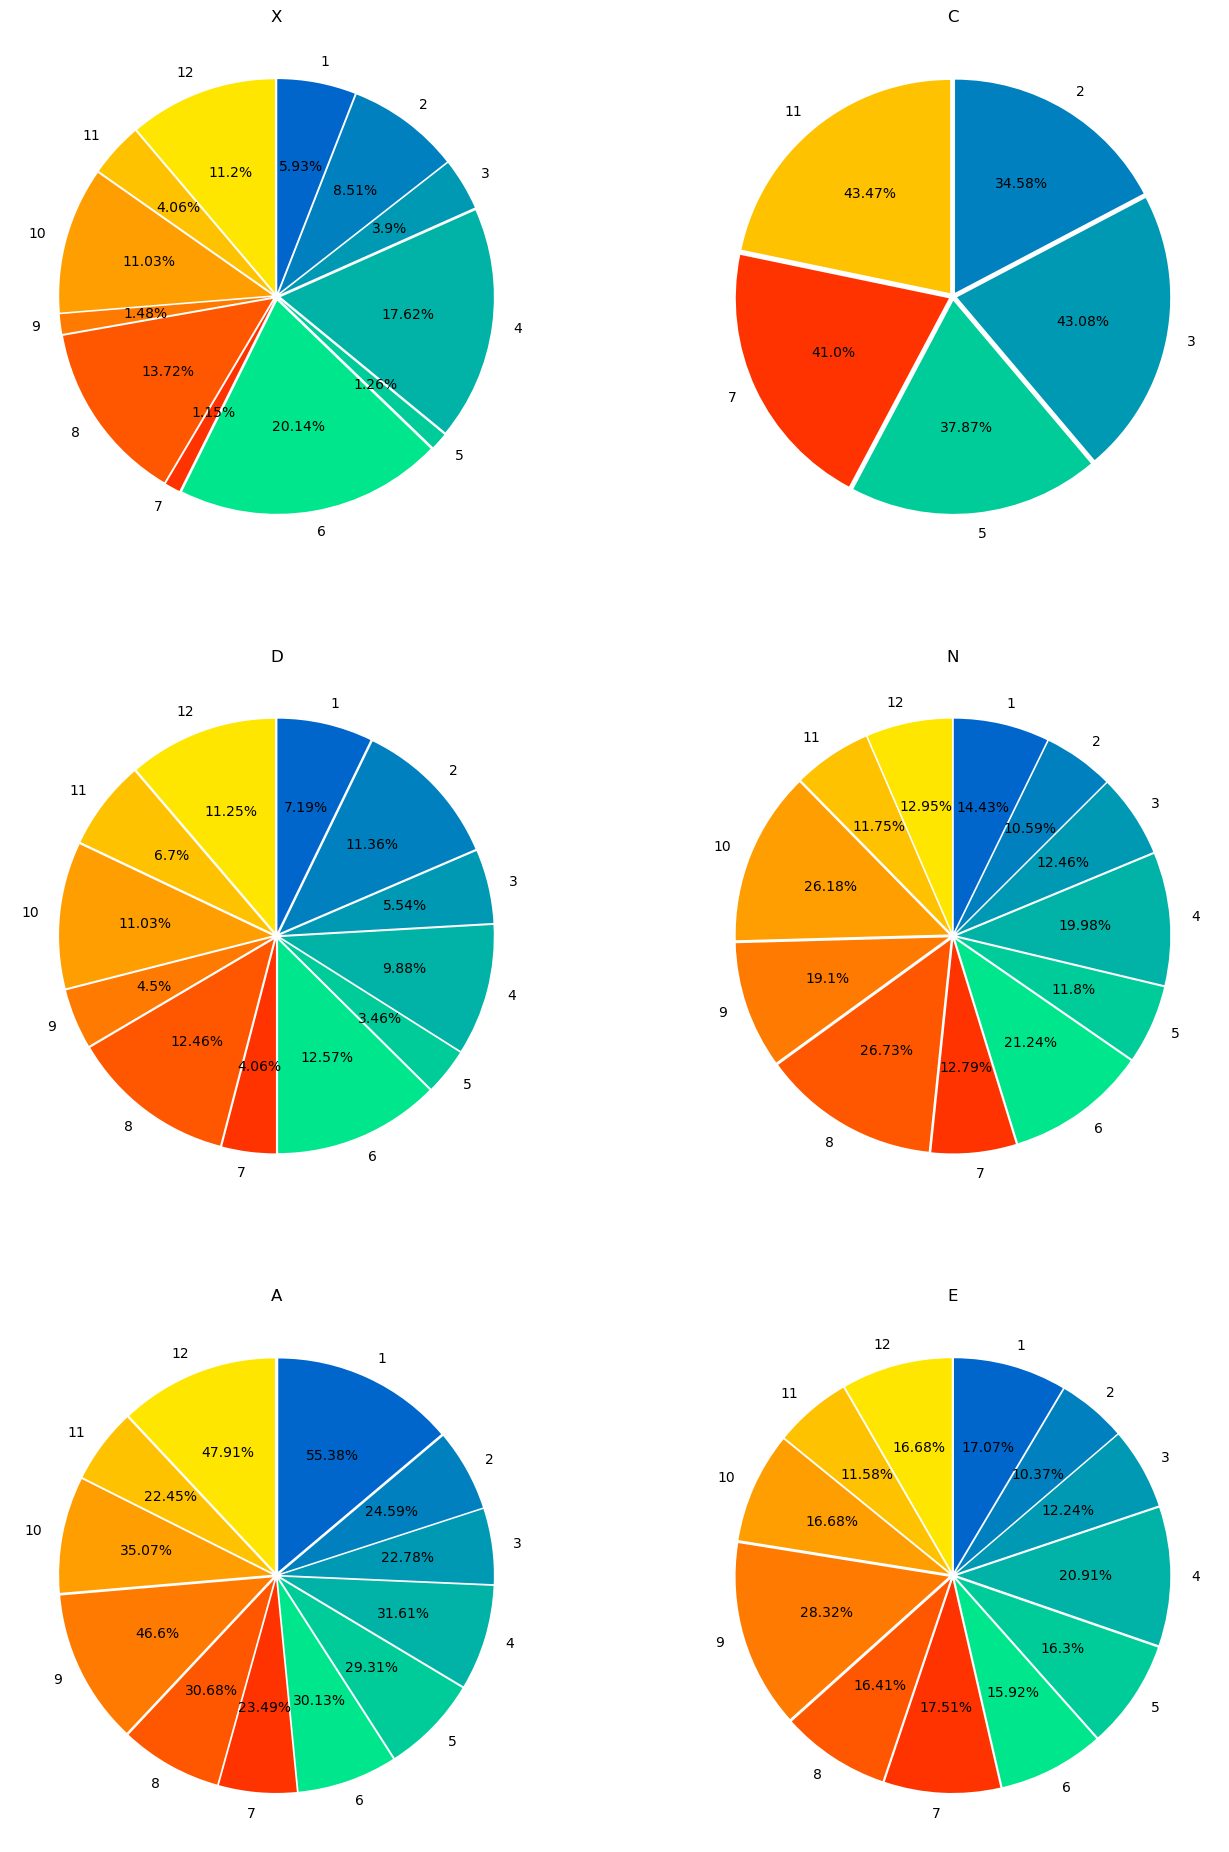

In [77]:
visualise_objects_prob(real_basic_situations)